# **Trabalho 1 - Reconhecimento de Padrões**
### Implementação Algoritmo Nearest Centroid
##### Renan Henrique Cardoso - 379013

In [1]:
import numpy as np                         # Algumas operações entre arrays optei usar o array do numpy
from scipy import io                       # Utilizado somente a função loadmat para carregar arquivo .mat 
import seaborn as sns                      # Plotagem
import matplotlib.pyplot as plt            # Plotagem
import pandas as pd                        # Utilizado para converter o .mat e trabalhar também com dataframes
pd.options.mode.chained_assignment = None  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Upload dos arquivos .mat**

In [2]:
!curl -o Classe1.mat --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://github.com/cardosorrenan/reconhecimentopadroes-ufc/blob/master/Classe1.mat?raw=true
!curl -o Classe2.mat --remote-name -H 'Accept: application/vnd.github.v3.raw' --location https://github.com/cardosorrenan/reconhecimentopadroes-ufc/blob/master/Classe2.mat?raw=true

### **Plot exemplo de sinal ECG**

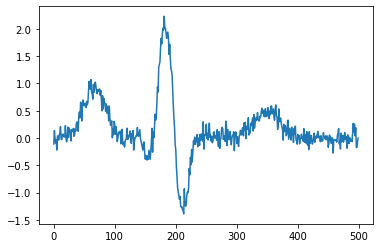

In [3]:
ecgs = io.loadmat('Classe1.mat')['Classe1']  # Carrega para 'ecgs' o arquivo Classe1.mat
ecgs = pd.DataFrame(ecgs)                    # Transforma do formato dicionário para dataframe
sns.lineplot(data=ecgs[49])                  # Exibe o sinal exemplo 50

### **Plot exemplo de sinal de ruído**

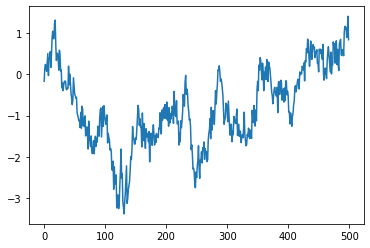

In [4]:
noises = io.loadmat('Classe2.mat')['Classe2']  
noises = pd.DataFrame(noises)                 
sns.lineplot(data=noises[13])                  

### **Características dos sinais elegidas**:
  - **Média**
  - **Mediana**
  - **Variância**
  - **Curtose** (Kurtosis): Medida de forma que caracteriza o achatamento da curva da função de distribuição de probabilidade
  - **Assimetria** (Skewness): Medida da assimetria da distribuição de probabilidade de uma variável aleatória com valor real sobre sua média

### **Definindo vetor de características para os sinais de ECG**

In [5]:
ecg_vector = pd.DataFrame()                           # Instancia um novo DataFrame
ecg_vector['mean'] = ecgs.mean()                      # Calcula a média de cada sinal ecg
ecg_vector['median'] = ecgs.median()                  # Calcula a mediana de cada sinal ecg
ecg_vector['variance'] = ecgs.var()                   # Calcula a variância de cada sinal ecg
ecg_vector['kurtosis'] = ecgs.kurtosis()              # Calcula a curtose de cada sinal ecg
ecg_vector['skewness'] = ecgs.skew()                  # Calcula a assimetria de cada sinal ecg
ecg_vector['class_kind'] = np.zeros(ecg_vector.shape[0])   # Definindo a classe dos sinais ecg: 0
print('ecg_vector', ecg_vector.shape)                 # Exibe dimensão do dataframe
ecg_vector.head()                                     # Exibe 5 amostras de sinais ecg

ecg_vector (50, 6)


,mean,median,variance,kurtosis,skewness,class_kind
0,0.054555,0.029564,0.044934,7.342880,0.712121,0.0
1,0.219775,0.121604,0.772401,7.525372,0.524423,0.0
2,0.006182,0.003271,0.000600,7.949215,0.598263,0.0
3,0.175649,0.092538,0.429686,7.802710,0.710876,0.0
4,0.249563,0.147590,0.927059,7.554545,0.695768,0.0


### **Definindo vetor de características para os sinais de ruído**

In [6]:
noise_vector = pd.DataFrame()
noise_vector['mean'] = noises.mean()
noise_vector['median'] = noises.median()
noise_vector['variance'] = noises.var()
noise_vector['kurtosis'] = noises.kurtosis()
noise_vector['skewness'] = noises.skew()
noise_vector['class_kind'] = np.ones(noise_vector.shape[0])
print('noise_vector', noise_vector.shape)
noise_vector.head()

noise_vector (50, 6)


,mean,median,variance,kurtosis,skewness,class_kind
0,0.002110,0.003533,0.000173,-1.013604,-0.308855,1.0
1,0.087184,0.171650,0.300552,-0.987618,-0.332647,1.0
2,0.154969,0.307802,1.159563,-0.964448,-0.344421,1.0
3,0.043552,0.089607,0.093389,-0.975847,-0.357878,1.0
4,0.026380,0.055927,0.027955,-0.976322,-0.330218,1.0


### **Definindo dataset**

In [7]:
dataset = ecg_vector.append(noise_vector) # Concatena os dois vetores das classes
dataset = dataset.sample(frac=1)          # Embaralha as linhas
dataset = dataset.reset_index(drop=True)  # Reset dos índices criados nas células anteriores
print('dataset', dataset.shape)
dataset.head(5)                           # Exibe as 5 primeiras amostras do nosso dataset

dataset (100, 6)


,mean,median,variance,kurtosis,skewness,class_kind
0,-0.332860,-0.220518,1.876899,-0.381101,-0.224919,1.0
1,-0.032301,0.047417,1.015810,-0.991589,-0.128255,1.0
2,0.079402,0.040989,0.086323,6.355578,0.728649,0.0
3,-1.510160,-1.713045,2.968756,-0.444928,-0.163112,1.0
4,0.123165,0.062362,0.211706,6.697356,0.796105,0.0


# **Algoritmo k-NN**

### **Variáveis de configuração do algoritmo**

In [8]:
n_neighbours = 5   # Quantidade de vizinhos mais próximos que o algoritmo k-NN levará em consideração
n_fold = 10        # Quantidade de partes que o dataset será dividido (cross-validation)

### **Rotulação dos sinais (delimitação dos folds)**

In [9]:
dataset['fold'] = pd.DataFrame(data=[-1]*dataset.shape[0])  # Todas as linhas da coluna 'fold' recebe -1, pois ainda não pertencem a nenhum fold
for fold in list(range(0, dataset.shape[0], n_fold)):       # Como K=10, cada linha pertencerá a um fold [0, 1, ..., 9] 
  dataset.loc[fold:fold+n_fold, 'fold'] = fold/n_fold       # 0-10 será 0-Fold / 10-20 será 1-Fold / ... / 90-100 será 9-Fold

### **Funções construídas**

In [10]:
#  Função que calcula a distância euclidiana entre dois pontos
def getEuclidianDistance(point_a, point_b):
  d2_mean = pow(point_a['mean'] - point_b['mean'], 2)
  d2_median = pow(point_a['median'] - point_b['median'], 2)
  d2_variance = pow(point_a['variance'] - point_b['variance'], 2)
  d2_kurtosis = pow(point_a['kurtosis'] - point_b['kurtosis'], 2)
  d2_skewness = pow(point_a['skewness'] - point_b['skewness'], 2)
  sum = d2_mean + d2_median + d2_variance + d2_kurtosis + d2_skewness
  return round(pow(sum,1/2), 6)


#  Obtém as coordenadas de cada centróide
def getCentroids(training_data):
  # Centroid 0
  signals_class0 = training_data.query('class_kind == 0')
  signals_class0 = signals_class0.drop(['class_kind', 'fold'], axis=1)
  n_signals0 = signals_class0.shape[0]
  centroid_0 = signals_class0.sum()/n_signals0
  centroid_0 = centroid_0.to_frame(name='centroid_0').T
  # Centroid 1
  signals_class1 = training_data.query('class_kind == 1')
  signals_class1 = signals_class1.drop(['class_kind', 'fold'], axis=1)
  n_signals1 = signals_class1.shape[0]
  centroid_1 = signals_class1.sum()/n_signals1
  centroid_1 = centroid_1.to_frame(name='centroid_1').T
  return centroid_0.append(centroid_1)


#  Retorna as distâncias entre os pontos de teste e os centróides
def getDistanceFromCentroids(testing_data, centroids):
  testing_data = testing_data.drop(['class_kind', 'fold'], axis=1)
  distances_df = pd.DataFrame()
  for index1, point_test in testing_data.iterrows():
    distances_column = pd.DataFrame()
    for index2, point_centroid in centroids.iterrows():
      distance = getEuclidianDistance(point_test, point_centroid)
      distance_row = pd.DataFrame({ f'{index1}': distance}, [f'{index2}'])
      distances_column = distances_column.append(distance_row)
    distances_df = pd.concat([distances_df, distances_column], axis=1)
  return distances_df


#  Retorna o centróide mais perto de cada ponto de teste
def getPredictedClass(row):
  near_centroid = row.idxmin()
  return 0 if near_centroid == 'centroid_0' else 1


#  Compara dois arrays e retorna a porcentagem de acertos
def compare(x, y):
  truth_array = np.equal(np.array(x), np.array(y))
  return np.sum(truth_array)/len(truth_array) * 100

### **Loop principal**

In [11]:
%%time
acc_total = 0

for validation in list(range(0, n_fold)):
  training_data = dataset.query(f'fold != {validation}')           # Total de 90 amostras em cada rodada do cross-validation
  testing_data = dataset.query(f'fold == {validation}')            # Total de 10 amostras em cada rodada do cross-validation
  centroids = getCentroids(training_data)                          # Obtém os centróides (Marcado com X Azul no plot)                 
  distances_df = getDistanceFromCentroids(testing_data, centroids) # Calcula as distâncias
  predict_classes = distances_df.apply(getPredictedClass)          # Obtém vetor de classes julgando pelo centróide mais perto
  predict_classes = predict_classes.rename('class_kind')           
  accuracy = compare(predict_classes, testing_data['class_kind'])  # Compara com as classes que realmente elas pertencem e retorna a acurácia
  acc_total += accuracy
  print(f'{validation}-Fold: Accuracy {accuracy}%')

print(f'\nAccuracy Total: {acc_total/n_fold} %')

0-Fold: Accuracy 100.0%
1-Fold: Accuracy 100.0%
2-Fold: Accuracy 100.0%
3-Fold: Accuracy 100.0%
4-Fold: Accuracy 100.0%
5-Fold: Accuracy 100.0%
6-Fold: Accuracy 100.0%
7-Fold: Accuracy 100.0%
8-Fold: Accuracy 100.0%
9-Fold: Accuracy 100.0%

Accuracy Total: 100.0 %
CPU times: user 685 ms, sys: 28.4 ms, total: 714 ms
Wall time: 676 ms


# **Alguns insights do algoritmo** (resultados da última validação)

In [12]:
dataset.head()

,mean,median,variance,kurtosis,skewness,class_kind,fold
0,-0.332860,-0.220518,1.876899,-0.381101,-0.224919,1.0,0.0
1,-0.032301,0.047417,1.015810,-0.991589,-0.128255,1.0,0.0
2,0.079402,0.040989,0.086323,6.355578,0.728649,0.0,0.0
3,-1.510160,-1.713045,2.968756,-0.444928,-0.163112,1.0,0.0
4,0.123165,0.062362,0.211706,6.697356,0.796105,0.0,0.0


In [13]:
centroids.head()

,mean,median,variance,kurtosis,skewness
centroid_0,0.161723,0.076370,0.412558,6.290406,0.739710
centroid_1,-0.209881,-0.158617,1.127257,-0.671628,-0.205919


In [14]:
distances_df.head()

,90,91,92,93,94,95,96,97,98,99
centroid_0,2.157189,2.292160,1.034875,7.739232,8.013364,0.473229,7.418156,6.748622,6.669449,7.356408
centroid_1,4.997959,4.901939,8.072177,1.889505,2.453430,7.308342,0.854868,0.542237,1.170118,1.191051


In [15]:
predict_classes

90    0
91    0
92    0
93    1
94    1
95    0
96    1
97    1
98    1
99    1
Name: class_kind, dtype: int64

### **Substituindo as classes do dataset original pelas preditas para plotagem do resultado**

In [16]:
testing_data = testing_data.drop(['class_kind'], axis=1)
testing_data['class_kind'] = predict_classes.values

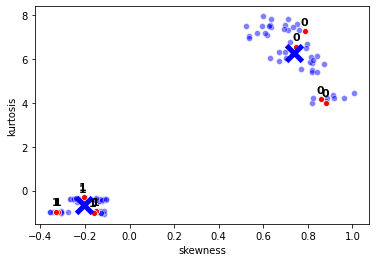

In [17]:
sns.scatterplot(x=training_data['skewness'], y=training_data['kurtosis'], color='blue', alpha=0.5)
ax = sns.scatterplot('skewness', 'kurtosis', data=testing_data, color='red')

plt.xlabel('skewness')
plt.ylabel('kurtosis')

def label_point(x, y, val, ax):
  a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
  for i, point in a.iterrows():
    ax.text(point['x']-0.02, point['y']+0.3, str(int(point['val'])), fontSize=11, fontWeight='extra bold')

label_point(testing_data['skewness'], testing_data['kurtosis'], testing_data['class_kind'], plt.gca())
sns.scatterplot(x=centroids['skewness'], y=centroids['kurtosis'], s=250, color='blue', marker='x', linewidth=5)